# [第10章: ベクトル空間法 (II)](http://www.cl.ecei.tohoku.ac.jp/nlp100/#ch10)
第10章では，前章に引き続き単語ベクトルの学習に取り組む．

## 90. word2vecによる学習
81で作成したコーパスに対して[word2vec](https://code.google.com/p/word2vec/)を適用し，単語ベクトルを学習せよ．さらに，学習した単語ベクトルの形式を変換し，86-89のプログラムを動かせ．

In [1]:
!ls Output/Chapter9/81.txt

Output/Chapter9/81.txt


In [1]:
from gensim.models.word2vec import Word2Vec
from tqdm import tqdm

In [3]:
%%time
model = None

with open("Output/Chapter9/81.txt") as f:
    sentences = [line.replace("\n", "").split() for line in tqdm(f)]
    model = Word2Vec(sentences=sentences, size=300, seed=90)
    model.save("Output/Chapter10/90_word2vec.model")

284434it [00:02, 141200.31it/s]


CPU times: user 3min 4s, sys: 1.31 s, total: 3min 6s
Wall time: 1min 17s


In [2]:
model = Word2Vec.load("Output/Chapter10/90_word2vec.model")

In [5]:
# 86
model.wv["United_States"].shape

(300,)

In [6]:
# 86
model.wv["United_States"]

array([ 2.2056072 ,  0.23797153, -0.32921836,  0.47713012, -0.22696011,
       -1.3468328 , -0.6965469 ,  1.5750383 ,  2.0900877 ,  0.6173464 ,
       -0.60352635, -0.10734959, -1.1178272 , -1.0017172 ,  0.59014404,
        0.85129   ,  0.6314024 , -0.36382258,  0.51196027, -0.5345813 ,
        0.34991196, -1.2022761 , -0.93957376,  0.23977031, -0.01586397,
       -1.0798851 ,  0.06522913,  1.3168948 , -0.31785753,  0.49251235,
        0.65566784, -0.5107309 ,  0.37079474,  0.32484797, -1.5810126 ,
       -0.48663917, -0.2901325 ,  0.327655  , -0.51501805, -0.01867462,
        1.6689357 ,  0.8086889 ,  0.79546916,  0.9805552 , -0.65693635,
       -0.63790965,  0.05999496,  0.60563964,  0.0576582 ,  0.25350642,
       -0.23809116,  0.79494035,  0.42077702,  1.5223198 ,  1.4085655 ,
        0.61609113, -0.08235477, -0.11829191, -1.3095598 ,  0.2187884 ,
        0.26629207,  0.82218623,  0.6380575 , -0.60547984,  0.53090596,
       -0.21515298, -0.71982366,  0.3724946 ,  0.9698897 ,  1.48

In [7]:
# 87
model.wv.n_similarity(["United_States"], ["U.S"])

0.85844314

In [8]:
# 88
for i, (word, cos_sim) in enumerate(model.wv.similar_by_word("England", topn=10)):
    args = (i+1, word, cos_sim)
    print("[%d/10] %s : %f" % args)

[1/10] Scotland : 0.775545
[2/10] Wales : 0.771095
[3/10] Ireland : 0.641085
[4/10] Sweden : 0.612036
[5/10] Britain : 0.591447
[6/10] Hampshire : 0.574492
[7/10] London : 0.564641
[8/10] Liverpool : 0.562679
[9/10] Manchester : 0.560126
[10/10] Plymouth : 0.555277


In [9]:
# 89
x_greece = model.wv["Spain"] - model.wv["Madrid"] + model.wv["Athens"]
for i, (word, cos_sim) in enumerate(model.wv.similar_by_vector(x_greece, topn=10)):
    args = (i+1, word, cos_sim)
    print("[%d/10] %s : %f" % args)

[1/10] Spain : 0.888941
[2/10] Italy : 0.818233
[3/10] Austria : 0.788470
[4/10] Portugal : 0.775220
[5/10] Egypt : 0.772404
[6/10] Greece : 0.765626
[7/10] Sweden : 0.760077
[8/10] Germany : 0.755487
[9/10] Denmark : 0.754107
[10/10] Hungary : 0.733094


## 91. アナロジーデータの準備
[単語アナロジーの評価データ](https://raw.githubusercontent.com/svn2github/word2vec/master/questions-words.txt)をダウンロードせよ．このデータ中で": "で始まる行はセクション名を表す．例えば，": capital-common-countries"という行は，"capital-common-countries"というセクションの開始を表している．ダウンロードした評価データの中で，"family"というセクションに含まれる評価事例を抜き出してファイルに保存せよ．

In [10]:
!ls Input/questions-words.txt

Input/questions-words.txt


In [11]:
with open("Input/questions-words.txt") as f, open("Output/Chapter10/91.txt", "w") as f_91:
    is_family = False
    for line in f:
        if line == ": family\n":
            is_family = True
            continue
        if not is_family:
            continue

        if line[:2] == ": ":
            break
        else:
            f_91.write(line)

## 92. アナロジーデータへの適用
91で作成した評価データの各事例に対して，vec(2列目の単語) - vec(1列目の単語) + vec(3列目の単語)を計算し，そのベクトルと類似度が最も高い単語と，その類似度を求めよ．求めた単語と類似度は，各事例の末尾に追記せよ．このプログラムを85で作成した単語ベクトル，90で作成した単語ベクトルに対して適用せよ．

In [3]:
import numpy as np
import pickle

In [4]:
%%time
t_list, c_list = None, None

with open("Output/Chapter9/83_f_t.txt") as f_83_t, open("Output/Chapter9/83_f_c.txt") as f_83_c:
    t_list = [line.split()[1] for line in f_83_t]
    c_list = [line.split()[1] for line in f_83_c]

print("len(t_list)=%d, len(c_list)=%d" % (len(t_list), len(c_list)))

len(t_list)=382481, len(c_list)=382901
CPU times: user 201 ms, sys: 35.8 ms, total: 237 ms
Wall time: 782 ms


In [5]:
X_85 = None

with open("Output/Chapter9/85_X_comp.pickle", "rb") as f_85:
    X_85 = pickle.load(f_85)

X_85.shape

(382481, 300)

In [15]:
def cossim_for_X_85(x: np.ndarray, y: np.ndarray):
    if np.linalg.norm(x) == 0 or np.linalg.norm(y) == 0:
        return -1
    else:
        return np.dot(x,y) / (np.linalg.norm(x)*np.linalg.norm(y))

In [16]:
# 85
with open("Output/Chapter10/91.txt") as f_91, open("Output/Chapter10/92_from_85.txt", "w") as f_92:
    for line in tqdm(f_91):
        word, cossim, elements = "???", -1.0, line.replace("\n", "").split()

        # 91.txtの1~3列目の単語のいずれかが、コーパスに存在しない場合は、
        # ベクトルが算出できないため、類似度が最も高い単語は"???"、その類似度は-1.0として出力
        if elements[0] in t_list and elements[1] in t_list and elements[2] in t_list:
            indices = (t_list.index(elements[0]), t_list.index(elements[1]), t_list.index(elements[2]))
            x = X_85[indices[1]] - X_85[indices[0]] + X_85[indices[2]]
            cossims = [cossim_for_X_85(x, X_85[i]) for i in range(len(t_list))]
            idx = np.argmax(cossims)
            word, cossim = t_list[idx], cossims[idx]

        args = (line.replace("\n", ""), word, cossim)
        f_92.write("%s %s %f\n" % args)

506it [28:27,  3.37s/it]


In [17]:
# 90
with open("Output/Chapter10/91.txt") as f_91, open("Output/Chapter10/92_from_90.txt", "w") as f_92:
    for line in tqdm(f_91):
        word, cossim, elements = "???", -1.0, line.replace("\n", "").split()

        # 91.txtの1~3列目の単語のいずれかが、コーパスに存在しない場合は、
        # ベクトルが算出できないため、類似度が最も高い単語は"???"、その類似度は-1.0として出力
        if elements[0] in model.wv and elements[1] in model.wv and elements[2] in model.wv:
            x = model.wv[elements[1]] - model.wv[elements[0]] + model.wv[elements[2]]
            word, cossim = model.wv.similar_by_vector(x, topn=1)[0]

        args = (line.replace("\n", ""), word, cossim)
        f_92.write("%s %s %f\n" % args)

506it [00:01, 288.48it/s]


## 93. アナロジータスクの正解率の計算
92で作ったデータを用い，各モデルのアナロジータスクの正解率を求めよ．

In [18]:
with open("Output/Chapter10/92_from_85.txt") as f_from_85, open("Output/Chapter10/92_from_90.txt") as f_from_90:
    accuracies = []

    for f in [f_from_85, f_from_90]:
        total, correct = 0, 0
        for line in f:
            total += 1
            elements = line.replace("\n", "").split()
            if elements[3] == elements[4]:
                correct += 1
        accuracies.append(100.0 * correct / total)

    print("85 Model:%f%%, 90 Model:%f%%" % (accuracies[0], accuracies[1]))

85 Model:1.778656%, 90 Model:9.486166%


## 94. WordSimilarity-353での類似度計算
[The WordSimilarity-353 Test Collection](http://www.cs.technion.ac.il/~gabr/resources/data/wordsim353/)の評価データを入力とし，1列目と2列目の単語の類似度を計算し，各行の末尾に類似度の値を追加するプログラムを作成せよ．このプログラムを85で作成した単語ベクトル，90で作成した単語ベクトルに対して適用せよ．

### 注意
2020年4月19日現在、[The WordSimilarity-353 Test Collection](http://www.cs.technion.ac.il/~gabr/resources/data/wordsim353/)の評価データのリンクが切れているため、[WordSim353 - Similarity and Relatednessを用いて何らかの評価を行った結果のデータ](http://alfonseca.org/pubs/ws353simrel.tar.gz)の中からwordsim353_agreed.txtを借用し、それを成形することで代用した。

In [19]:
!ls Input/wordsim353_agreed.txt

Input/wordsim353_agreed.txt


In [20]:
with open("Input/wordsim353_agreed.txt") as f, open("Output/Chapter10/94_wordsim-353.txt", "w") as f_94:
    for line in f:
        if line[0] == "#":
            continue
        elements = line.split()
        f_94.write("%s\t%s\t%s\n" % (elements[1], elements[2], elements[3]))

In [21]:
!ls Output/Chapter10/94_wordsim-353.txt

Output/Chapter10/94_wordsim-353.txt


In [22]:
# 85
with open("Output/Chapter10/94_wordsim-353.txt") as f, open("Output/Chapter10/94_from_85.txt", "w") as f_94:
    for line in tqdm(f):
        cossim, elements = -1.0, line.replace("\n", "").split()

        # 94_wordsim-353.txtの1~2列目の単語のいずれかが、コーパスに存在しない場合は、
        # ベクトルが算出できないため、類似度を-1.0として出力
        if elements[0] in t_list and elements[1] in t_list:
            indices = (t_list.index(elements[0]), t_list.index(elements[1]))
            cossim = cossim_for_X_85(X_85[indices[0]], X_85[indices[1]])

        args = (line.replace("\n", ""), cossim)
        f_94.write("%s %f\n" % args)

352it [00:04, 82.49it/s]


In [23]:
# 90
with open("Output/Chapter10/94_wordsim-353.txt") as f, open("Output/Chapter10/94_from_90.txt", "w") as f_94:
    for line in tqdm(f):
        cossim, elements = -1.0, line.replace("\n", "").split()

        # 94_wordsim-353.txtの1~2列目の単語のいずれかが、コーパスに存在しない場合は、
        # ベクトルが算出できないため、類似度を-1.0として出力
        if elements[0] in model.wv and elements[1] in model.wv:
            cossim = model.wv.n_similarity([elements[0]], [elements[1]])

        args = (line.replace("\n", ""), cossim)
        f_94.write("%s %f\n" % args)

352it [00:00, 24418.96it/s]


## 95. WordSimilarity-353での評価
94で作ったデータを用い，各モデルが出力する類似度のランキングと，人間の類似度判定のランキングの間のスピアマン相関係数を計算せよ．

In [6]:
from scipy.stats import spearmanr

In [25]:
with open("Output/Chapter10/94_from_85.txt") as f_from_85, open("Output/Chapter10/94_from_90.txt") as f_from_90:
    correlations = []

    for f in [f_from_85, f_from_90]:
        cossims, humans = [], []
        for line in f:
            elements = line.replace("\n", "").split()
            cossims.append(float(elements[3]))
            humans.append(float(elements[2]))

        correlations.append(spearmanr(cossims, humans)[0])

    print("85 Model:%f%%, 90 Model:%f%%" % (correlations[0], correlations[1]))

85 Model:0.090700%, 90 Model:0.508218%


## 96. 国名に関するベクトルの抽出
word2vecの学習結果から，国名に関するベクトルのみを抜き出せ．

In [136]:
!wc -l Input/country_names_96.txt

182 Input/country_names_96.txt


In [4]:
countries = None

with open("Input/country_names_96.txt") as f:
    countries = [line.replace("\n", "").replace(" ", "_") for line in f]

In [5]:
X_96 = np.array([model.wv[country] for country in countries])
X_96.shape

(183, 300)

## 97. k-meansクラスタリング
96の単語ベクトルに対して，k-meansクラスタリングをクラスタ数k=5として実行せよ．

In [139]:
from sklearn.cluster import KMeans

In [143]:
kmeans = KMeans(n_clusters=5, random_state=97)
kmeans.fit(X_96)
kmeans.labels_

array([3, 0, 0, 4, 0, 4, 4, 0, 2, 3, 0, 4, 4, 0, 4, 4, 3, 4, 4, 4, 0, 4,
       4, 3, 4, 3, 4, 4, 0, 4, 2, 4, 4, 0, 2, 0, 4, 4, 4, 4, 0, 0, 0, 4,
       3, 4, 4, 4, 4, 3, 4, 4, 0, 0, 3, 3, 4, 4, 0, 3, 0, 3, 4, 4, 0, 4,
       4, 4, 4, 3, 0, 2, 0, 0, 3, 2, 4, 2, 4, 4, 2, 4, 4, 0, 4, 2, 0, 4,
       4, 4, 4, 0, 4, 4, 0, 4, 0, 4, 3, 4, 4, 0, 4, 4, 4, 4, 4, 4, 2, 4,
       4, 4, 0, 4, 0, 4, 4, 4, 4, 0, 3, 2, 4, 4, 0, 4, 3, 4, 2, 4, 0, 4,
       0, 0, 3, 3, 4, 4, 3, 3, 4, 4, 0, 0, 4, 3, 4, 0, 0, 4, 4, 4, 3, 0,
       4, 4, 3, 0, 0, 4, 0, 0, 4, 4, 4, 4, 3, 4, 4, 4, 0, 0, 4, 1, 0, 4,
       4, 4, 0, 3, 4, 4, 4], dtype=int32)

In [145]:
for label in range(5):
    print("[Label No.%d]" % label)
    for idx in np.where(kmeans.labels_ == label)[0]:
        print(countries[idx])
    print()

[Label No.0]
Albania
Algeria
Angola
Armenia
Azerbaijan
Bangladesh
Bolivia
Cambodia
Chile
Colombia
Croatia
Cuba
Cyprus
Ethiopia
Fiji
Georgia
Ghana
Guinea
Iceland
Indonesia
Iran
Kenya
Kosovo
Lebanon
Libya
Lithuania
Malaysia
Mongolia
Morocco
Nepal
Nigeria
Panama
Peru
Philippines
Samoa
Saudi
Singapore
Slovakia
Sudan
Swiss
Syria
Tanzania
Thailand
Uganda
Ukraine
Uruguay
Venezuela

[Label No.1]
United_States

[Label No.2]
Australia
Canada
China
India
Ireland
Israel
Japan
Korea
Mexico
New_Zealand
Pakistan

[Label No.3]
Afghanistan
Austria
Belgium
Brazil
Bulgaria
Denmark
Egypt
Finland
France
Germany
Greece
Hungary
Iraq
Macedonia
Netherlands
Norway
Poland
Portugal
Romania
Russia
Serbia
Spain
Sweden
Turkey
Vietnam

[Label No.4]
Andorra
Antigua_and_Barbuda
Argentine
Bahamas
Bahrain
Barbados
Belarus
Belize
Benin
Bhutan
Bosnia_and_Herzegovina
Botswana
Brunei
Burkina_Faso
Burundi
Cameroon
Central_African_Republic
Chad
Comoros
Congo
Congo
Cook_Islands
Czech
Djibouti
Dominica
Dominican_Republic
Ecuador

## 98. Ward法によるクラスタリング
96の単語ベクトルに対して，Ward法による階層型クラスタリングを実行せよ．さらに，クラスタリング結果をデンドログラムとして可視化せよ．

In [6]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, ward
import seaborn as sns

In [7]:
%matplotlib inline

In [8]:
sns.set(style="darkgrid", context="notebook", palette="muted")

CPU times: user 157 ms, sys: 24.1 ms, total: 181 ms
Wall time: 151 ms


(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 <a list of 10 Text major ticklabel objects>)

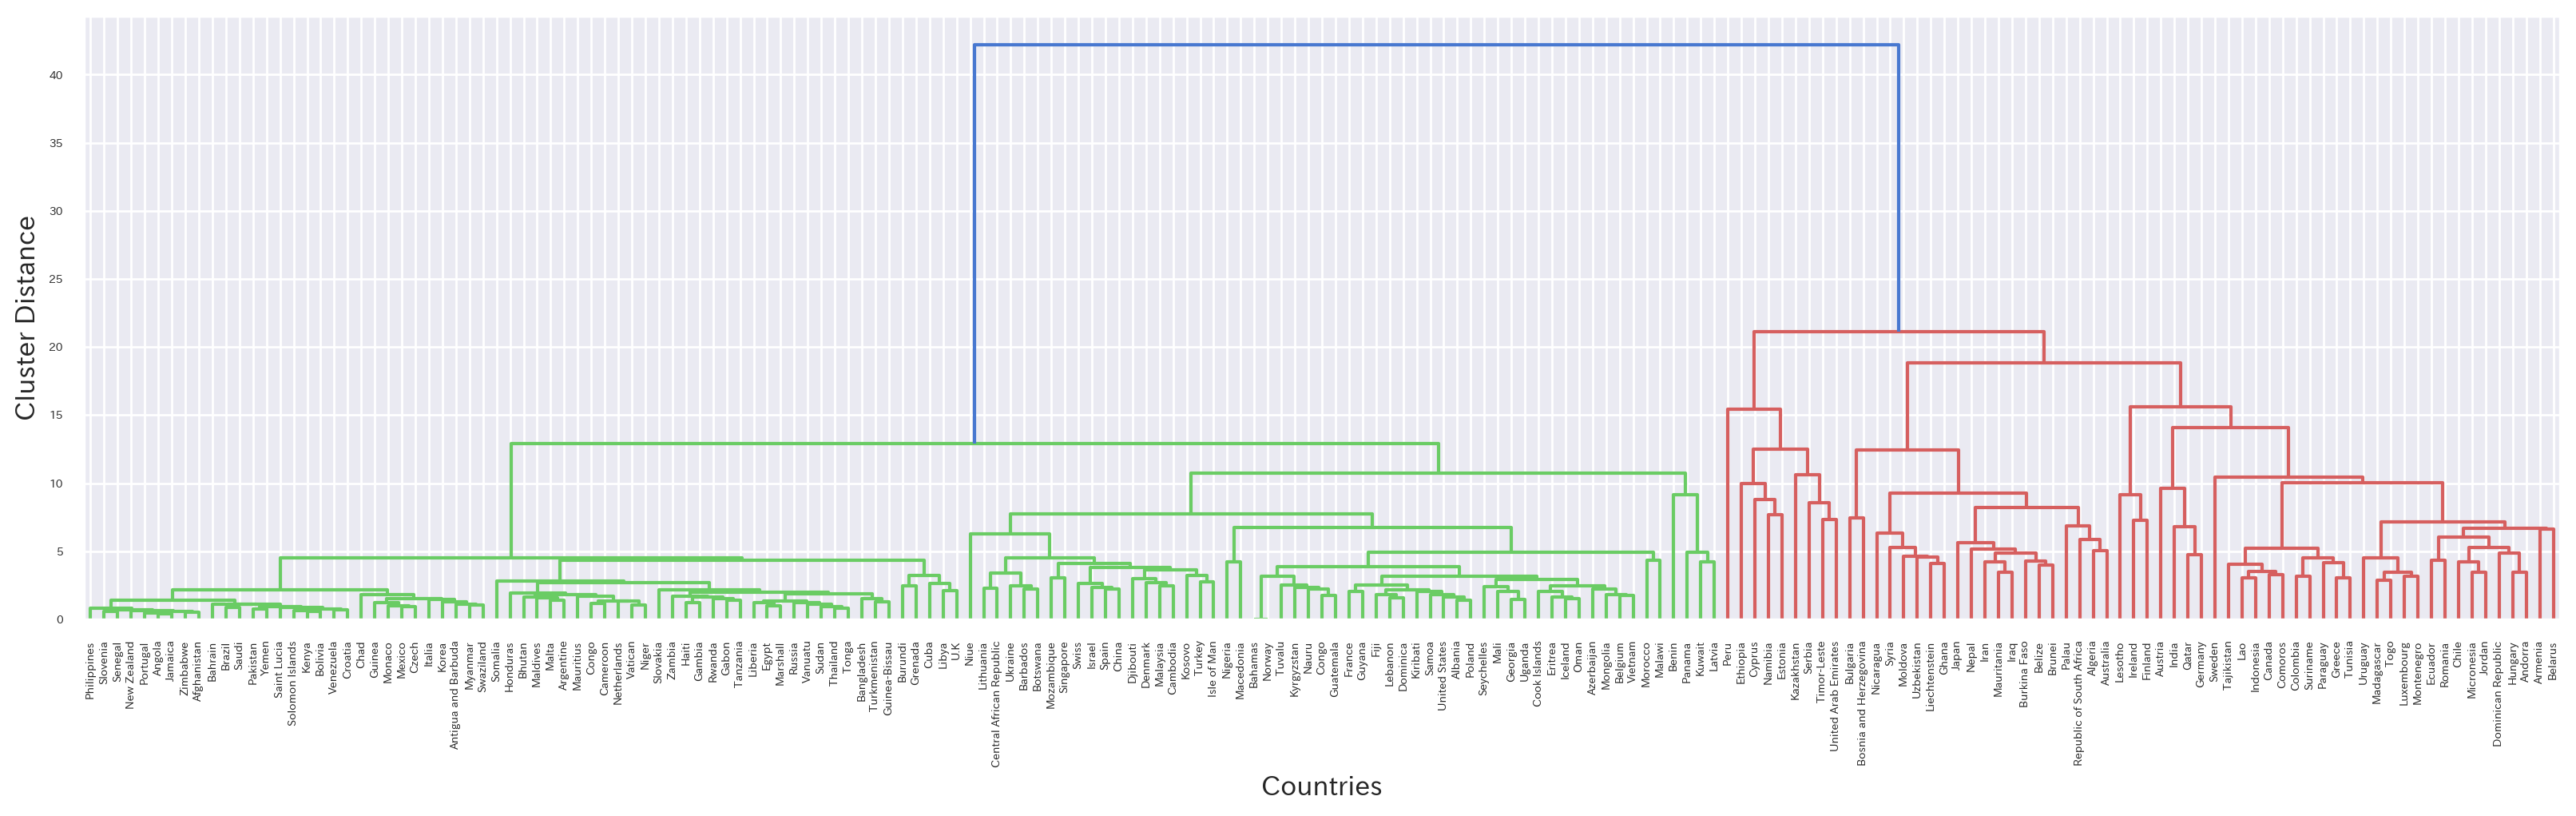

In [9]:
%%time
linkage = ward(X_96)
out_98 = dendrogram(linkage, no_plot=True)

plt.figure(dpi=200, figsize=(20,5))
dendrogram(linkage, labels=[countries[int(label)-1].replace("_", " ")
                            for label in out_98["ivl"]])
plt.xlabel("Countries")
plt.ylabel("Cluster Distance")
plt.yticks(fontsize=5)

## 99. t-SNEによる可視化
96の単語ベクトルに対して，ベクトル空間をt-SNEで可視化せよ．

In [10]:
from sklearn.manifold import TSNE

CPU times: user 2.61 s, sys: 156 ms, total: 2.76 s
Wall time: 694 ms


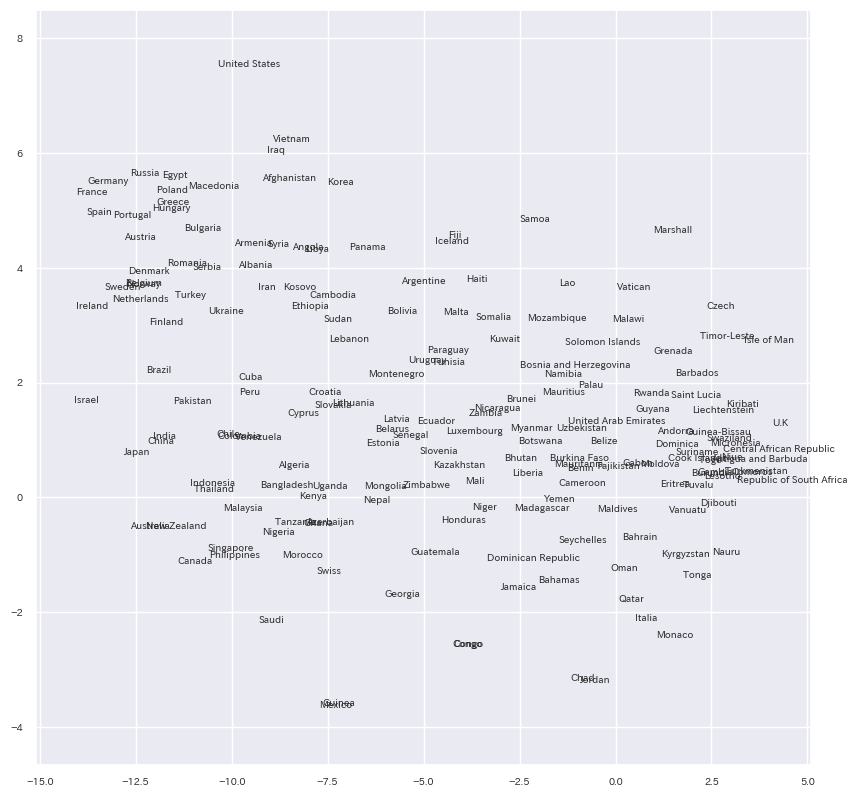

In [18]:
%%time
out_99 = TSNE(random_state=99).fit_transform(X_96)
plt.figure(dpi=100, figsize=(10,10))
plt.xlim(out_99[:,0].min()-1, out_99[:,0].max()+1)
plt.ylim(out_99[:,1].min()-1, out_99[:,1].max()+1)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
for idx, country in enumerate(countries):
    plt.text(out_99[idx,0], out_99[idx,1], country.replace("_", " "), fontsize=7)